## TF-IDF on clusters (sentiment)
### Loading partitioning on sentiment 

OBS alt kode herunder er et udklip med små ændringer fra Mads's kode, så denne fil kan også køres efter "sentiment.ipynb"

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math
from sklearn.cluster import KMeans
import numpy as np
import json

# Load Graph
G_path = Path("G_mother.graphml")
G = nx.read_graphml(str(G_path)) 

In [2]:
# print example of node with all attributes and keys
example_node = list(G.nodes(data=True))[0]
print("Example node attributes:", example_node)
print(example_node[1].keys())  # print attribute keys

Example node attributes: ('Missy_Elliott', {'songs': '["Lose Control (feat. Ciara & Fat Man Scoop)", "Work It", "Gossip Folks (feat. Ludacris)", "One Minute Man (feat. Ludacris)", "Get Ur Freak On", "Pep Rally", "WTF (Where They From) [feat. Pharrell Williams]"]', 'albums': '["Under Construction", "Miss E...So Addictive", "Pep Rally", "The Cookbook", "WTF (Where They From) [feat. Pharrell Williams]"]', 'playlists': '[0, 203, 779, 112, 912, 218, 127]', 'num_playlists': 7, 'num_songs': 7, 'avg_song_duration': 236137.08333333334, 'lyrics': '\n\nIs it worth it? Let me work it\nI put my thing down, flip it and reverse it\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP\nIf you got a big— let me search ya\nAnd find out how hard I gotta work ya\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP\n\u200bti esrever dna ti pilf ,nwod gniht ym tuP (C\'mon)\n\nI\'d like to get to know ya so I could show ya\nPut the pussy on ya like I told ya\nGive me a

In [3]:
# --- 2. PREPARE VECTORS ---
node_ids = []
vectors = []

for node in G.nodes():
    # 1. Get the string attribute
    vec_str = G.nodes[node].get('lyric_vector')
    
    if vec_str:
        try:
            # 2. Convert JSON string back to Numpy Array
            vec = np.array(json.loads(vec_str))
            vectors.append(vec)
            node_ids.append(node)
        except:
            pass # Skip nodes with corrupted data

X = np.array(vectors)

# To get the number of partitions from the structural analysis (Louvain)
louvain_communities = list(nx.community.louvain_communities(G, seed=42))
num_comm = len(louvain_communities)

# This groups artists purely by how similar their lyrics are (Cosine distance logic)
kmeans = KMeans(n_clusters=num_comm, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Create the partition dictionary: {node_id: cluster_id}
lyric_partition = {node: int(label) for node, label in zip(node_ids, labels)}


OBS her stopper MADS's kode igen ;)

In [4]:
# calculate mean value of sentiment of each label, using all nodes within the label
cluster_sentiments = {}
cluster_sizes = {}

for node in G.nodes():
    sentiment = G.nodes[node].get('sentiment_compound')
    cluster_id = lyric_partition.get(node)
    if sentiment is not None and cluster_id is not None:
        cluster_sentiments.setdefault(cluster_id, 0)
        cluster_sizes.setdefault(cluster_id, 0)
        cluster_sentiments[cluster_id] += float(sentiment)
        cluster_sizes[cluster_id] += 1
# Calculate average sentiment for each cluster
for cid in cluster_sentiments:
    cluster_sentiments[cid] /= cluster_sizes[cid]

# print with lowest sentiment first
for cid, avg_sentiment in sorted(cluster_sentiments.items(), key=lambda x: x[1]):
    print(f"Cluster {cid}: Average Sentiment = {avg_sentiment:.4f}")

Cluster 9: Average Sentiment = -0.3952
Cluster 6: Average Sentiment = -0.2271
Cluster 0: Average Sentiment = 0.4140
Cluster 4: Average Sentiment = 0.4275
Cluster 8: Average Sentiment = 0.5567
Cluster 1: Average Sentiment = 0.6323
Cluster 5: Average Sentiment = 0.6343
Cluster 7: Average Sentiment = 0.6977
Cluster 3: Average Sentiment = 0.7425
Cluster 2: Average Sentiment = 0.7443


We expect cluster 9 to have more sad words, cluster 0 to be more average or without sentiment, and cluster 3 to be more happy.

In the following we create TF lists and IDF word counts of the tokens/words of the sentiment partitioned artists. 

- We have filtered out words that appear less than 5 times, and all punctuation. 
- We have also made all characters lower case. 
- We also remove some stop words
- We normalize TF by the total tokens per partition.

In [5]:
# Compute IDF
def compute_idf(df, N, method="smooth"):
    if method == "standard":
        return math.log10(N / df)
    elif method == "smooth":
        return math.log10(N / (1 + df)) + 1
    elif method == "prob":
        return math.log10((N - df) / df)

In [6]:
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
# Creating TF-IDF analysis

lemmatizer = WordNetLemmatizer()
stopwords = set(ENGLISH_STOP_WORDS)

# remove sound words like 'oh', 'la', 'na', 'yeah', 'ooh'
sound_words = {'oh', 'la', 'na', 'yeah', 'ooh', 'uh', 'ta', 'ah', 'hoo', 'ha', 'mm', 
               'hmm', 'da', 'wo', 'woah', 'whoa', 'hey', 'ay', 'ayyy', 'woo', 'woohoo',
               'ra-ta-ta-ta-ta-ta-ta-ta-ta-ta', 'dum', 'dum-dum', 'la-la-la', 'na-na-na', 'laa', 'laaa',
               'naaa', 'naaaa', 'yeaaah', 'yeaah', 'yeaaaah', 'ooh-ooh', 'uh-huh', 'mm-hmm',
               'ba-bum-bum-bum-bum', 'bom', 'bom-bom', 'da-da-da', 'da-da', 'duh', 'duh-duh', 'la-la',
               'na-na', 'na-na-na-na', 'whoa-oh', 'whoa-oh-oh', 'woo-woo', 'woo-woo-woo', 'yah', 'yahh',
               'ba-bum-bum-bum-bum', 'ba-bum-bum-bum-bum-bum', 'oh-oh', 'oh-oh-oh', 'uh-oh', 'uh-oh-oh','ooh-ooh-ooh',
               'woo-hoo','m-m-m-m-m', 'oh-nah-nah-nah','mmm-mm-hmm-mm', 'mm-mm-hmm', 'hmmm-mm'}
uninteresting_words = {"i'm", "im", "ive", "i've", "youre", "you're","we're", "were", "hes", "he's", "it's", "its",
                       "shes", "she's", "thats", "that's", "whats", "what's", "couldnt", "i'll", "ill", "youll", "you'll",
                       "he'll", "she'll", "we'll", "well", "they'll", "theyll", "isnt", "isn't", "wasnt", "wasn't",
                       "werent", "weren't", "dont", "don't", "doesnt", "doesn't", "wont", "won't", "let's", "lets",
                       "shouldnt", "shouldn't", "mightnt", "mightn't", "mustnt", "mustn't", "hadnt", "hadn't","let",
                       "couldn't", "wouldnt", "wouldn't", "didnt", "didn't", "got", "gonna","there's"}
stopwords.update(sound_words)
stopwords.update(uninteresting_words)

import re
from collections import Counter, defaultdict

# Parameters
min_word_count = 5   # filter words that occur less than this across a cluster
top_k_per_cluster = 200


### BUILD TF and TF-IDF per LYRIC CLUSTER

In [8]:
# BUILD TF and TF-IDF per LYRIC CLUSTER
import re
from collections import Counter, defaultdict

# Parameters
min_word_count = 5   # filter words that occur less than this across a cluster
top_k_per_cluster = 200

# Build TF lists aggregated by lyrical cluster (lyric_partition: {node: cluster_id})
cluster_counts = defaultdict(Counter) # this will be {cluster_id: Counter({word: count, ...}), ...}
cluster_token_totals = defaultdict(int) # total tokens per cluster

for node, data in G.nodes(data=True):
    if node not in lyric_partition:
        continue
    lyrics = str(data.get('lyrics', ''))
    if len(lyrics) < 50: # making sure that we can display at least 50 words for an artist
        continue

    # tokenize + normalize + lemmatize
    lyrics = lyrics.replace("’", "'").lower()
    tokens = re.findall(r"\b[a-z']{2,}\b", lyrics)          # alphabetic tokens, len>=2
    lemmas = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]

    # update cluster counters
    cid = int(lyric_partition[node])
    cluster_counts[cid].update(lemmas)
    cluster_token_totals[cid] += len(lemmas)

# Filter infrequent words within each cluster and compute IDF across clusters
cluster_TF = {} # {cluster_id: Counter({word: count, ...}), ...}
IDF_counts_cluster = Counter()
for cid, counter in cluster_counts.items():
    # keep only words that occur at least `min_word_count` in this cluster
    filtered = Counter({w: c for w, c in counter.items() if c >= min_word_count})
    cluster_TF[cid] = filtered
    # update document frequency (word appears in this cluster)
    for w in filtered:
        IDF_counts_cluster[w] += 1

num_cluster_docs = len(cluster_TF)

# Compute TF-IDF per cluster
cluster_TFIDF = {}
for cid, counter in cluster_TF.items():
    total = sum(counter.values()) or 1
    tfidf = {}
    for w, cnt in counter.items():
        tf = cnt / total
        df = IDF_counts_cluster.get(w, 0)
        idf = compute_idf(df, num_cluster_docs, method="smooth")   # uses compute_idf from notebook
        tfidf[w] = tf * idf
    # sort by tfidf desc
    cluster_TFIDF[cid] = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:top_k_per_cluster]

# Save results in dicts
TF_lists_by_cluster = {cid: list(counter.items()) for cid, counter in cluster_TF.items()}
TFIDF_lists_by_cluster = cluster_TFIDF

We can now visualize the difference between the TF and TF-IDF in wordclouds. We have chosen to display the top 50 words to make it possible to distinguish between the words but still get a large representation. 

In [9]:
from wordcloud import WordCloud

def plot_tf_vs_tfidf(TF_lists_by_cluster, TFIDF_lists_by_cluster, clusters=None, NUM_WORDS=50, n=6,
                     tf_title="TF (raw counts)", tfidf_title="TF-IDF (top terms)",
                     wc_kwargs=None, figsize_per_row=(12,3),
                     plot_tf=True, plot_tfidf=True,
                     show_cluster_label=True, custom_titles=None):
    """
    Plot TF vs TF-IDF wordclouds for clusters.
      - TF_lists_by_cluster: {cid: [(word,count), ...], ...}
      - TFIDF_lists_by_cluster: {cid: [(word,score), ...], ...}
      - clusters: optional list of cluster ids to plot (ordered). If None, choose top-n by TF size.
      - n: number of clusters to plot
      - plot_tf / plot_tfidf: booleans to control which column(s) to draw
      - show_cluster_label: if True, prefix title with "Cluster X —"; if False, use custom_titles
      - custom_titles: dict {cid: "custom title"} or list of titles (one per cluster)
    """
    wc_kwargs = wc_kwargs or {"background_color":"white", "width":600, "height":400}
    # choose clusters if not provided
    if clusters is None:
        # rank clusters by total TF tokens (fallback to len of TF list)
        ranking = sorted(TF_lists_by_cluster.keys(),
                         key=lambda c: sum(count for _, count in TF_lists_by_cluster.get(c, [])),
                         reverse=True)
        clusters = ranking[:n]
    else:
        clusters = list(clusters)[:n]

    rows = len(clusters)
    cols = int(bool(plot_tf)) + int(bool(plot_tfidf))

    if rows == 0 or cols == 0:
        print("No clusters or no plot columns selected.")
        return

    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_row[0], figsize_per_row[1]*rows))
    # normalize axes to 2D array for consistent indexing
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes]).reshape(1, cols)
    elif cols == 1:
        axes = np.array(axes).reshape(rows, 1)

    for i, cid in enumerate(clusters):
        col_idx = 0
        # TF frequencies dict
        tf_pairs = TF_lists_by_cluster.get(cid, [])
        tf_freq = {w: c for w, c in tf_pairs}
        # TF-IDF dict (use scores directly)
        tfidf_pairs = TFIDF_lists_by_cluster.get(cid, [])
        tfidf_freq = {w: score for w, score in tfidf_pairs}

        # Determine custom title for this cluster
        if custom_titles is not None:
            if isinstance(custom_titles, dict):
                custom_title = custom_titles.get(cid, "")
            elif isinstance(custom_titles, list) and i < len(custom_titles):
                custom_title = custom_titles[i]
            else:
                custom_title = ""
        else:
            custom_title = ""

        if plot_tf:
            ax = axes[i, col_idx]
            if tf_freq:
                wc_tf = WordCloud(**wc_kwargs, max_words=NUM_WORDS).generate_from_frequencies(tf_freq)
                ax.imshow(wc_tf, interpolation='bilinear')
                if show_cluster_label:
                    ax.set_title(f"Cluster {cid} — {tf_title}")
                else:
                    ax.set_title(custom_title if custom_title else tf_title)
            else:
                ax.text(0.5,0.5,"No TF data", ha='center', va='center')
            ax.axis('off')
            col_idx += 1

        if plot_tfidf:
            ax = axes[i, col_idx]
            if tfidf_freq:
                max_score = max(tfidf_freq.values()) or 1.0
                scaled = {w: (s/max_score) for w,s in tfidf_freq.items()}
                wc_tfidf = WordCloud(**wc_kwargs, max_words=NUM_WORDS).generate_from_frequencies(scaled)
                ax.imshow(wc_tfidf, interpolation='bilinear')
                if show_cluster_label:
                    ax.set_title(f"Cluster {cid} — {tfidf_title}")
                else:
                    ax.set_title(custom_title if custom_title else tfidf_title)
            else:
                ax.text(0.5,0.5,"No TF-IDF data", ha='center', va='center')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

### Plot wordclouds

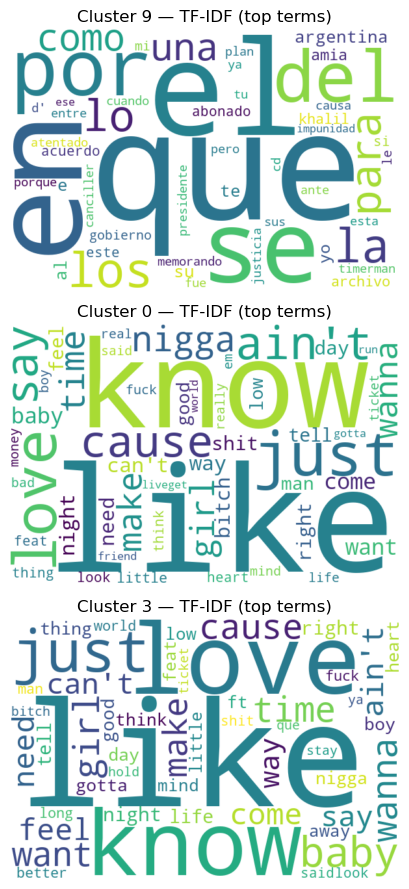

In [10]:
# plot cluster 9, 0 and 3
plot_tf_vs_tfidf(TF_lists_by_cluster, TFIDF_lists_by_cluster, NUM_WORDS=50, clusters=[9,0,3],plot_tf=False, plot_tfidf=True)

In [11]:
# plot list of all artists in cluster 9, 0 and 1
for cid in [9,0,3]:
    artists_in_cluster = [node for node, c in lyric_partition.items() if c == cid]
    print(f"Cluster {cid} artists ({len(artists_in_cluster)}):")
    for artist in artists_in_cluster:
        print(f" - {artist}")

Cluster 9 artists (37):
 - Selena
 - Shakira
 - Sonora_Carruseles
 - Sebastian_Yatra
 - Ozuna
 - Romeo_Santos
 - Deorro
 - Nach
 - Yandel
 - Reik
 - Voz_De_Mando
 - Don_Omar
 - J_Balvin
 - Luis_Fonsi
 - Skrillex
 - Karol_G
 - Lary_Over
 - Maluma
 - Noriel
 - Pepe_Quintana
 - Juanes
 - Daddy_Yankee
 - Farruko
 - Charly_Black
 - Heroes_Del_Silencio
 - Grupo_Niche
 - Cosculluela
 - Alfredo_Olivas
 - Alta_Consigna
 - Ariel_Camacho_y_Los_Plebes_Del_Rancho
 - El_Fantasma
 - Los_Plebes_del_Rancho_de_Ariel_Camacho
 - Virlan_Garcia
 - Bad_Bunny
 - Bryant_Myers
 - Alexis_y_Fido
 - Gilberto_Santa_Rosa
Cluster 0 artists (87):
 - Ne-Yo
 - The_National
 - Demi_Lovato
 - Jonas_Brothers
 - Jennifer_Lopez
 - Machine_Gun_Kelly
 - Kevin_Abstract
 - Caribou
 - Hannah_Montana
 - Travie_McCoy
 - Mary_Wells
 - Pharrell_Williams
 - The_Beatles
 - Wale
 - The_White_Stripes
 - Rick_James
 - The_Kinks
 - The_Offspring
 - JoJo
 - Travis_Scott
 - Jimmy_Eat_World
 - Wiz_Khalifa
 - Thomas_Rhett
 - Marina_and_the_Dia

## TF-IDF on cliques

In [12]:
# find all cliques
cliques = list(nx.find_cliques(G))
print(f"Number of cliques in the graph: {len(cliques)}")

# analyze clique size distribution
clique_sizes = [len(clique) for clique in cliques]
size_counts = pd.Series(clique_sizes).value_counts().sort_index()
print("Clique size distribution:")
print(size_counts)

Number of cliques in the graph: 16931
Clique size distribution:
2     322
3    3622
4    6204
5    4082
6    1855
7     679
8     157
9      10
Name: count, dtype: int64


We will filter out 2 and 3 cliques, as these are not meaningfull for our analysis. 

In [13]:
# remove all cliques with more less than 4 members
filtered_cliques = [clique for clique in cliques if len(clique) >= 4]
print(f"Number of cliques with size >= 4: {len(filtered_cliques)}")

Number of cliques with size >= 4: 12987


In [14]:
# Find average cosine similarity of lyric vectors within each clique
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)


In [15]:
# find average cosine similarity of lyric vectors within each clique
average_cosine_sims_of_cliques = []
for clique in filtered_cliques:
    vectors = []
    for node in clique:
        vector_str = G.nodes[node].get('lyric_vector')
        if vector_str:
            vector = np.array(json.loads(vector_str))
            vectors.append(vector)
    # compute pairwise cosine similarities
    sims = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            sim = cosine_similarity(vectors[i], vectors[j])
            sims.append(sim)
    # average similarity for this clique
    if sims:
        avg_sim = sum(sims) / len(sims)
        average_cosine_sims_of_cliques.append(avg_sim)


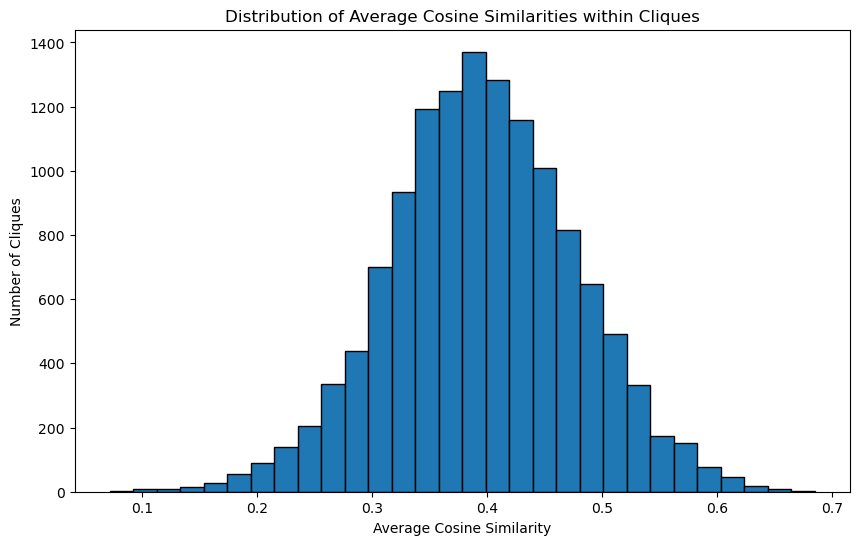

In [16]:
# plot in histogram
plt.figure(figsize=(10, 6))
plt.hist(average_cosine_sims_of_cliques, bins=30, edgecolor='black')
plt.title("Distribution of Average Cosine Similarities within Cliques")
plt.xlabel("Average Cosine Similarity")
plt.ylabel("Number of Cliques")
plt.show()


In [17]:
# extract 9-cliques
from collections import defaultdict
nine_cliques = [clique for clique in cliques if len(clique) == 9]

clique_sentiments = defaultdict(list)
print(f"Number of 9-cliques: {len(nine_cliques)}")
for clique in nine_cliques:
    key = tuple(clique)
    for artist in clique:
        # calculate average sentiment
        sentiment = G.nodes[artist].get('sentiment_compound')
        clique_sentiments[key].append(float(sentiment))

# compute average sentiment per 9-clique and print sorted low->high
avg_by_clique = []
for key, sentiments in clique_sentiments.items():
    if sentiments:
        avg_sent = sum(sentiments) / len(sentiments)
        avg_by_clique.append((avg_sent, key))

# sort by average sentiment ascending (low -> high)
avg_by_clique.sort(key=lambda x: x[0])

for avg_sent, clique_key in avg_by_clique:
    print(f"Average Sentiment = {avg_sent:.4f} ; {list(clique_key)}")

Number of 9-cliques: 10
Average Sentiment = -0.3255 ; ['2Pac', 'Twista', 'Soulja_Boy', 'Ludacris', 'Trick_Daddy', 'Three_6_Mafia', 'Trina', 'Bubba_Sparxxx', 'Busta_Rhymes']
Average Sentiment = -0.3231 ; ['Twista', '50_Cent', 'Soulja_Boy', 'Trick_Daddy', 'Three_6_Mafia', 'Trina', 'Ludacris', 'Fat_Joe', 'Lil_Jon']
Average Sentiment = -0.1109 ; ['Twista', '50_Cent', 'Soulja_Boy', 'Trick_Daddy', 'Three_6_Mafia', 'Trina', 'Sean_Paul', 'Lil_Jon', 'Fat_Joe']
Average Sentiment = -0.1034 ; ['Bubba_Sparxxx', '50_Cent', 'Twista', 'Busta_Rhymes', 'Ludacris', 'Trick_Daddy', 'Three_6_Mafia', 'Soulja_Boy', 'Trina']
Average Sentiment = 0.3363 ; ['Spoon', 'The_Kills', 'Sylvan_Esso', 'Lewis_Del_Mar', 'Atlas_Genius', 'Cloud_Nothings', 'Kaleo', 'Kaskade', 'Matt_and_Kim']
Average Sentiment = 0.3364 ; ['Spoon', 'The_Kills', 'Sylvan_Esso', 'Lewis_Del_Mar', 'Atlas_Genius', 'Cloud_Nothings', 'Kaleo', 'Glass_Animals', 'Matt_and_Kim']
Average Sentiment = 0.3372 ; ['Spoon', 'The_Kills', 'Sylvan_Esso', 'Lewis_Del_

### TF-IDF for cliques
Now we can make TF-IDF on the first and last clique 

In [18]:
# Compute TF-IDF for the lowest and highest 9-cliques using the same assumptions as the cluster TF-IDF block

import re
from collections import Counter

# reuse notebook parameters if present, else set defaults
min_word_count = globals().get("min_word_count", 5)
top_k_per_cluster = globals().get("top_k_per_cluster", 200)
lemmatizer = globals().get("lemmatizer", None)
stopwords = globals().get("stopwords", None)

# ensure lemmatizer/stopwords available
if lemmatizer is None:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
if stopwords is None:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stopwords = set(ENGLISH_STOP_WORDS)

def tokenize_and_count_clique(nodes):
    counter = Counter()
    total_tokens = 0
    for node in nodes:
        lyrics = str(G.nodes[node].get("lyrics", "")).replace("’", "'").lower()
        if len(lyrics) < 50:   # same assumption as cluster block
            continue
        tokens = re.findall(r"\b[a-z']{2,}\b", lyrics)
        lemmas = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
        counter.update(lemmas)
        total_tokens += len(lemmas)
    return counter, total_tokens


In [19]:
# get the two target cliques (ensure avg_by_clique exists)
if "avg_by_clique" not in globals() or not avg_by_clique:
    raise RuntimeError("avg_by_clique not found or empty — run the 9-clique sentiment aggregation cell first.")

lowest_clique_nodes = list(avg_by_clique[0][1])
highest_clique_nodes = list(avg_by_clique[-1][1])
targets = {
    "lowest": lowest_clique_nodes,
    "highest": highest_clique_nodes
}

# build counters for both cliques
counters = {}
totals = {}
for k, nodes in targets.items():
    c, t = tokenize_and_count_clique(nodes)
    # filter using same min_word_count as cluster block
    filtered = Counter({w: cnt for w, cnt in c.items() if cnt >= min_word_count})
    counters[k] = filtered
    totals[k] = sum(filtered.values()) or 1

# IDF across the two clique-documents
IDF_counts = Counter()
for k, cnt in counters.items():
    for w in cnt:
        IDF_counts[w] += 1
num_docs = len(counters)  # typically 2

# compute TF-IDF for each clique (same idf method)
TFIDF_by_clique = {}
for k, cnt in counters.items():
    tfidf = {}
    total = totals[k]
    for w, c in cnt.items():
        tf = c / total
        df = IDF_counts.get(w, 0)
        idf = compute_idf(df, num_docs, method="smooth")   # uses compute_idf from notebook
        tfidf[w] = tf * idf
    TFIDF_by_clique[k] = {
        "TF": cnt.most_common(top_k_per_cluster),
        "TFIDF": sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:top_k_per_cluster]
    }

### Plot wordclouds

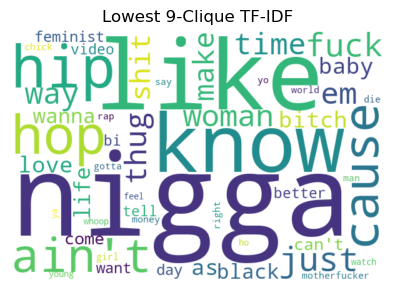

Average Sentiment for lowest 9-Clique: -0.3255
Clique: ['2Pac', 'Twista', 'Soulja_Boy', 'Ludacris', 'Trick_Daddy', 'Three_6_Mafia', 'Trina', 'Bubba_Sparxxx', 'Busta_Rhymes']


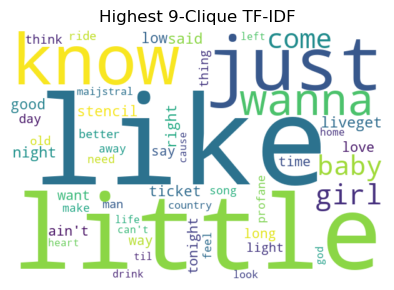

Average Sentiment for highest 9-Clique: 0.9956
Clique: ['Thompson_Square', 'Blake_Shelton', 'Carrie_Underwood', 'Cole_Swindell', 'Little_Big_Town', 'Randy_Houser', 'Jason_Aldean', 'Jon_Pardi', 'Joe_Nichols']


In [20]:
# print wordclouds and the sentiment score for the two 9-cliques using plot_tf_vs_tfidf
for k in ["lowest", "highest"]:
    plot_tf_vs_tfidf(
        TF_lists_by_cluster={0: TFIDF_by_clique[k]["TF"]},
        TFIDF_lists_by_cluster={0: TFIDF_by_clique[k]["TFIDF"]},
        clusters=[0],
        NUM_WORDS=50,
        n=1,
        plot_tf=False,
        plot_tfidf=True,
        show_cluster_label=False,
        custom_titles={0: f"{k.capitalize()} 9-Clique TF-IDF"}
    )
    # print average sentiment
    sentiments = clique_sentiments[tuple(targets[k])]
    avg_sent = sum(sentiments) / len(sentiments)
    print(f"Average Sentiment for {k} 9-Clique: {avg_sent:.4f}")
    print(f"Clique: {targets[k]}")

Here it is easy to see that theres actually a big difference in how the sentiment relates to the words.

TODO, skriv noget mere om disse

### Average weight inside all cliques vs avg similarity inside clique

We expect cliques that have a high average weight (meaning that they are highly connected and are featured on a lot of the same playlists) to have high semantic similarity, which means that we will see a positive relationship on the graph. 

In [21]:
# average weight inside all cliques vs avg similarity inside clique
# color all dots on the graph in each their own depending on clique size
# make a trend line in red in the graph

import matplotlib.pyplot as plt
from itertools import combinations

# build L2-normalized vectors for nodes (skip missing / zero vectors)
node_vecs = {}
for n, d in G.nodes(data=True):
    s = d.get('lyric_vector')
    if not s:
        continue
    v = np.array(json.loads(s), dtype=float)
    norm = np.linalg.norm(v)
    if norm == 0:
        continue
    node_vecs[n] = v / norm

# choose cliques to analyze (use filtered_cliques if available)
cliques_to_use = globals().get("filtered_cliques", globals().get("cliques", []))

sizes = []
avg_edge_weights = []
avg_cosine_sims = []

for clique in cliques_to_use:
    # edges: average weight
    edge_weights = []
    for u, v in combinations(clique, 2):
        if G.has_edge(u, v):
            w = G[u][v].get('weight', None)
            if w is not None:
                try:
                    edge_weights.append(float(w))
                except:
                    pass
    if not edge_weights:
        continue

    # vectors: only nodes that have vectors
    vec_nodes = [n for n in clique if n in node_vecs]
    if len(vec_nodes) < 2:
        continue

    V = np.vstack([node_vecs[n] for n in vec_nodes])
    sims = V @ V.T
    iu = np.triu_indices(len(V), k=1)
    mean_sim = float(sims[iu].mean())

    sizes.append(len(clique))
    avg_edge_weights.append(float(np.mean(edge_weights)))
    avg_cosine_sims.append(mean_sim)

# convert to arrays
sizes = np.array(sizes)
avg_edge_weights = np.array(avg_edge_weights)
avg_cosine_sims = np.array(avg_cosine_sims)


Pearson r between avg weight and avg similarity: 0.3320


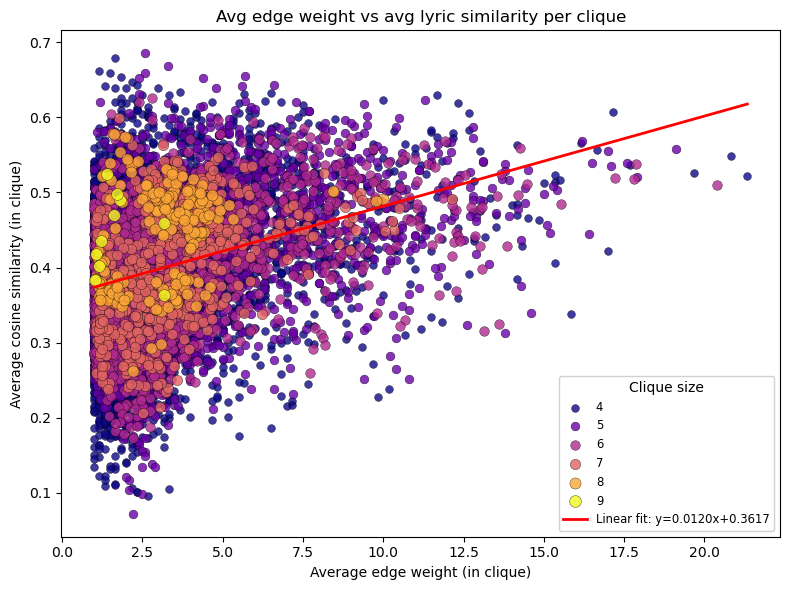

In [22]:
# discrete-size labeled scatter, plot smallest-first so larger markers are on top
plt.figure(figsize=(8,6))

unique_sizes = np.unique(sizes)
unique_sizes.sort()  # ascending -> plot smallest first

cmap = plt.cm.plasma
colors = {s: cmap(i / max(1, len(unique_sizes)-1)) for i, s in enumerate(unique_sizes)}

handles = []
for s in unique_sizes:
    mask = (sizes == s)
    if not mask.any():
        continue
    sc_handle = plt.scatter(avg_edge_weights[mask],
                            avg_cosine_sims[mask],
                            c=[colors[s]],
                            s=np.clip(s, 4, 50) * 8,
                            alpha=0.8,
                            edgecolor='k',
                            linewidth=0.3,
                            label=str(int(s)),
                            zorder=int(s))  # larger sizes have higher zorder
    handles.append(sc_handle)

plt.xlabel('Average edge weight (in clique)')
plt.ylabel('Average cosine similarity (in clique)')
plt.title('Avg edge weight vs avg lyric similarity per clique')

# linear trend (fit) drawn beneath points
if len(avg_edge_weights) > 1:
    coef = np.polyfit(avg_edge_weights, avg_cosine_sims, deg=1)
    x_line = np.linspace(np.nanmin(avg_edge_weights), np.nanmax(avg_edge_weights), 200)
    y_line = np.polyval(coef, x_line)
    plt.plot(x_line, y_line, color='red', linewidth=2, zorder=int(s)+1,
             label=f'Linear fit: y={coef[0]:.4f}x+{coef[1]:.4f}')

# Pearson correlation
if len(avg_edge_weights) > 1:
    r = np.corrcoef(avg_edge_weights, avg_cosine_sims)[0,1]
    print(f"Pearson r between avg weight and avg similarity: {r:.4f}")

# Legend inside plot in the southeast (lower right) corner
plt.legend(title='Clique size', loc='lower right', frameon=True, framealpha=0.9, fontsize='small')
plt.tight_layout()
plt.show()

## TF-IDF on clusters (louvain)

In [23]:
# extracting louvain communities from attributes on nodes in the graph G to calculate the sentiment inside each of the communities

# calculate mean value of sentiment of each louvain_label, using all nodes within the label
cluster_lou_sentiments = {}
cluster_lou_sizes = {}

for node in G.nodes():
    sentiment = G.nodes[node].get('sentiment_compound')
    louvain_id = G.nodes[node].get('louvain_community')
    if sentiment is not None and louvain_id is not None:
        cluster_lou_sentiments.setdefault(louvain_id, 0)
        cluster_lou_sizes.setdefault(louvain_id, 0)
        cluster_lou_sentiments[louvain_id] += float(sentiment)
        cluster_lou_sizes[louvain_id] += 1
# Calculate average sentiment for each louvain cluster
for cid in cluster_lou_sentiments:
    cluster_lou_sentiments[cid] /= cluster_lou_sizes[cid]

# print with lowest sentiment first
for cid, avg_lou_sentiment in sorted(cluster_lou_sentiments.items(), key=lambda x: x[1]):
    print(f"Cluster {cid}: Average Sentiment = {avg_lou_sentiment:.4f}")

Cluster 1: Average Sentiment = -0.3261
Cluster 0: Average Sentiment = -0.1798
Cluster 4: Average Sentiment = 0.4630
Cluster 6: Average Sentiment = 0.6029
Cluster 8: Average Sentiment = 0.6201
Cluster 3: Average Sentiment = 0.6899
Cluster 5: Average Sentiment = 0.7966
Cluster 7: Average Sentiment = 0.8403
Cluster 2: Average Sentiment = 0.8995


In [24]:
# calculate TF-IDF for lowest and highest clusters
import re
from collections import Counter

# reuse notebook parameters if present, else set defaults
min_word_count = globals().get("min_word_count", 5)
top_k_per_cluster = globals().get("top_k_per_cluster", 200)
lemmatizer = globals().get("lemmatizer", None)
stopwords = globals().get("stopwords", None)

# ensure lemmatizer/stopwords available
if lemmatizer is None:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
if stopwords is None:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stopwords = set(ENGLISH_STOP_WORDS)

In [25]:
# calculate TF-IDF for lowest and highest clusters
def tokenize_and_count_louvain_cluster(nodes):
    counter = Counter()
    total_tokens = 0
    for node in nodes:
        lyrics = str(G.nodes[node].get("lyrics", "")).replace("’", "'").lower()
        if len(lyrics) < 50:   # same assumption as cluster block
            continue
        tokens = re.findall(r"\b[a-z']{2,}\b", lyrics)
        lemmas = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
        counter.update(lemmas)
        total_tokens += len(lemmas)
    return counter, total_tokens

# get the two lowest and highest sentiment clusters
sorted_louvain = sorted(cluster_lou_sentiments.items(), key=lambda x: x[1])
lowest_louvain_id = sorted_louvain[0][0]
second_lowest_louvain_id = sorted_louvain[1][0]
highest_louvain_id = sorted_louvain[-1][0]

targets = {
    "lowest": [node for node in G.nodes() if G.nodes[node].get('louvain_community') == lowest_louvain_id],
    "second_lowest" : [node for node in G.nodes() if G.nodes[node].get('louvain_community') == second_lowest_louvain_id],
    "highest": [node for node in G.nodes() if G.nodes[node].get('louvain_community') == highest_louvain_id]
}

# build counters for both louvain clusters
counters = {}
totals = {}
for k, nodes in targets.items():
    c, t = tokenize_and_count_louvain_cluster(nodes)
    # filter using same min_word_count as cluster block
    filtered = Counter({w: cnt for w, cnt in c.items() if cnt >= min_word_count})
    counters[k] = filtered
    totals[k] = sum(filtered.values()) or 1
# IDF across the two clique-documents
IDF_counts = Counter()
for k, cnt in counters.items():
    for w in cnt:
        IDF_counts[w] += 1
num_docs = len(counters)  # typically 2

# compute TF-IDF for each clique (same idf method)
TFIDF_by_louvain = {}
for k, cnt in counters.items():
    tfidf = {}
    total = totals[k]
    for w, c in cnt.items():
        tf = c / total
        df = IDF_counts.get(w, 0)
        idf = compute_idf(df, num_docs, method="smooth")   # uses compute_idf from notebook
        tfidf[w] = tf * idf
    TFIDF_by_louvain[k] = {
        "TF": cnt.most_common(top_k_per_cluster),
        "TFIDF": sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:top_k_per_cluster]
    }


### Wordclouds for louvain clusters

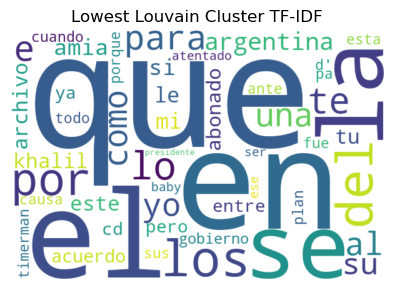

Average Sentiment for lowest Louvain Cluster: -0.3261
Cluster ID: 1


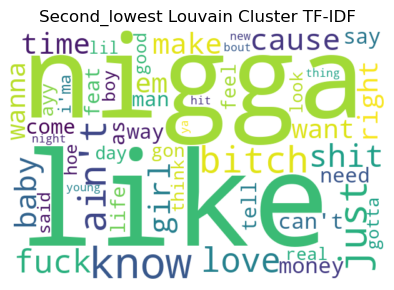

Average Sentiment for second_lowest Louvain Cluster: -0.1798
Cluster ID: 0


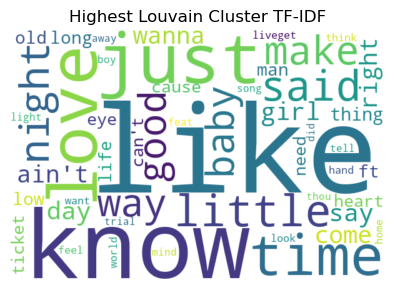

Average Sentiment for highest Louvain Cluster: 0.8995
Cluster ID: 2


In [26]:

# plot louvain clusters
for k in ["lowest", "second_lowest","highest"]:
    plot_tf_vs_tfidf(
        TF_lists_by_cluster={0: TFIDF_by_louvain[k]["TF"]},
        TFIDF_lists_by_cluster={0: TFIDF_by_louvain[k]["TFIDF"]},
        clusters=[0],
        NUM_WORDS=50,
        n=1,
        plot_tf=False,
        plot_tfidf=True,
        show_cluster_label=False,
        custom_titles={0: f"{k.capitalize()} Louvain Cluster TF-IDF"}
    )
    # print average sentiment
    avg_sent = cluster_lou_sentiments[lowest_louvain_id if k == "lowest" else second_lowest_louvain_id if k == "second_lowest" else highest_louvain_id]
    print(f"Average Sentiment for {k} Louvain Cluster: {avg_sent:.4f}")
    print(f"Cluster ID: {lowest_louvain_id if k == 'lowest' else second_lowest_louvain_id if k == 'second_lowest' else highest_louvain_id}")